# Exampville Destination Choice

In this notebook, we will walk through the estimation of a tour 
destination choice model for 
Exampville, an entirely fictional town built for the express purpose of 
demostrating the use of discrete choice modeling tools for transportation 
planning.

This example will assume the reader is familiar with the 
mathematical basics of destination choice
modeling generally, and will focus on the technical 
aspects of estimating the parameters
of a destination choice model in Python using Larch.

If you have not yet estimated parameters of a mode choice model
or generated logsums from that model, you should go back and
review those sections before you begin this one.

In [1]:
import larch, numpy, pandas, os
from larch import P, X

## Data Preparation

To begin, we will re-load the data files from our tour mode choice example.

In [2]:
import larch.exampville

hh = pandas.read_csv( larch.exampville.files.hh )
pp = pandas.read_csv( larch.exampville.files.person )
tour = pandas.read_csv( larch.exampville.files.tour )
skims = larch.OMX( larch.exampville.files.skims, mode='r' )

We'll also load an employment file. This file contains employment
data by TAZ.  The TAZ's will be the choices in the destination 
choice model, and the employment data will allow us to characterize
the number of opportunities in each TAZ.

In [3]:
emp = pandas.read_csv(larch.exampville.files.employment, index_col='TAZ')
emp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 1 to 40
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   NONRETAIL_EMP  40 non-null     int64
 1   RETAIL_EMP     40 non-null     int64
 2   TOTAL_EMP      40 non-null     int64
dtypes: int64(3)
memory usage: 1.2 KB


We'll also load the saved logsums from the mode choice estimation.

In [4]:
logsums = pandas.read_pickle('/tmp/logsums.pkl.gz')

We'll replicate the pre-processing used in the mode choice estimation,
to merge the household and person characteristics into the tours data,
add the index values for the home TAZ's, filter to include only 
work tours, and merge with the level of service skims. (If this 
pre-processing was computationally expensive, it would probably have
been better to save the results to disk and reload them as needed,
but for this model these commands will run almost instantaneously.)

In [5]:
co = tour.merge(hh, on='HHID').merge(pp, on=('HHID', 'PERSONID'))
co["HOMETAZi"] = co["HOMETAZ"] - 1
co["DTAZi"] = co["DTAZ"] - 1
co = co[co.TOURPURP == 1]
co.index.name = 'CASE_ID'

For this destination choice model, we'll want to use the mode choice
logsums we calculated previously, and we'll use these values as data.  The alternatives in
the destinations model are much more regular than in the mode choice 
model -- the utility function for each destination will have a common
form -- we'll use `idca` format to make data management simpler.  This
format maintains a data array in three dimensions instead of two: cases,
alternatives, and variables.  We can still use a pandas.DataFrame to
hold this data, but we'll use a `MultiIndex` for one of the typical 
dimensions.

We already have one `idca` format variable: the logsums we loaded above.
For a destination choice model, we'll often also want to use distance
--specifically, the distance from the known origin zone to each possible
destination zones.  We can create a distance variable as an array,
selecting for each case in the `co` data a row from the 'AUTO_DIST'
array that matches the correct origin zone (by index number).
Note that we first load the skim array into memory using `[:]` and then
select the rows, to overcome a technical limitation of the PyTables
library (which underpins the open matrix format) that prevents us 
from reading the final array directly from the file on disk.

In [6]:
distance = pandas.DataFrame(
    skims.AUTO_DIST[:][co["HOMETAZi"], :],
    index=co.index,
    columns=skims.TAZ_ID,
) 

The distance and logsum arrays are both currently formatted as 
single variables stored in two-dimensional format (cases by
alternatives) but to concatenate them together, we can use the 
`unstack` command to convert each into a one-dimensional array.
We'll also use the `rename` command to ensure that each 
one-dimensional array is named appropriately, so that when they
are concatenate the result will include the names of the 
variables.

In [7]:
ca = pandas.concat([
    distance.stack().rename("distance"),
    logsums.stack().rename("logsum"), 
], axis=1)

Now we have our two variables in the correct format:

In [8]:
ca.head()

distance    logsum
CASE_ID TAZ_ID                    
0       1       8.286090 -2.935713
        2       8.256698 -2.660536
        3       2.928829 -1.745670
        4       5.502758 -2.229338
        5       5.882862 -2.403182

We'll also need to join employment data to the `ca` DataFrame.  This data has unique 
values only by alternative and not by caseid, so there are only
40 unique rows.  

In [9]:
emp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 1 to 40
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   NONRETAIL_EMP  40 non-null     int64
 1   RETAIL_EMP     40 non-null     int64
 2   TOTAL_EMP      40 non-null     int64
dtypes: int64(3)
memory usage: 1.2 KB


But to make this work with the computational 
arrays required for Larch, we'll need to join this to the other 
idca data, like this:

In [10]:
ca = ca.join(emp, on='TAZ_ID')

We can also extract an 'Area Type' variable 
from the skims, and attach that as well:

In [11]:
area_type = pandas.Series(
    skims.TAZ_AREA_TYPE[:],
    index=skims.TAZ_ID[:],
    name ='TAZ_AREA_TYPE',
).astype('category')

In [12]:
ca = ca.join(area_type, on='TAZ_ID')

Then we bundle the raw data into the `larch.DataFrames` structure,
as we did for estimation, and attach this structure to the model
as its `dataservice`.

In [13]:
dfs = larch.DataFrames(
    co=co,
    ca=ca,
    alt_codes=skims.TAZ_ID, 
    alt_names=['TAZ{i}' for i in skims.TAZ_ID],
    ch_name='DTAZ',
    av=True,
)

In [14]:
dfs.info(1)

larch.DataFrames:  (not computation-ready)
  n_cases: 7564
  n_alts: 40
  data_ca:
    - distance      (302560 non-null float64)
    - logsum        (302560 non-null float64)
    - NONRETAIL_EMP (302560 non-null int64)
    - RETAIL_EMP    (302560 non-null int64)
    - TOTAL_EMP     (302560 non-null int64)
    - TAZ_AREA_TYPE (302560 non-null category)
  data_co:
    - TOURID        (7564 non-null int64)
    - HHID          (7564 non-null int64)
    - PERSONID      (7564 non-null int64)
    - DTAZ          (7564 non-null int64)
    - TOURMODE      (7564 non-null int64)
    - TOURPURP      (7564 non-null int64)
    - N_STOPS       (7564 non-null int64)
    - N_TRIPS_x     (7564 non-null int64)
    - N_TRIPS_HBW_x (7564 non-null int64)
    - N_TRIPS_HBO_x (7564 non-null int64)
    - N_TRIPS_NHB_x (7564 non-null int64)
    - X             (7564 non-null float64)
    - Y             (7564 non-null float64)
    - INCOME        (7564 non-null float64)
    - N_VEHICLES    (7564 non-null int64)

## Model Definition

In [15]:
m = larch.Model(dataservice=dfs)

Destination choice models are premised on the theory that each
trip or tour has a particular destination to which it is attracted,
and each travel zone represents not one individual alternative, 
but rather a number of similar alternatives grouped together.
Thus the utility function in a destination choice model typically is 
comprised of two components: a qualitative component (i.e., how
good are the alternatives in a zone) and a quantitative component
(i.e., how many discrete alternatives are in a zone).  The mathematical
form of the utility function for the zone is

$$\sum_i{\beta_i}X_i + \theta\log\left(\sum_j{\exp(\gamma_j)}Z_j\right)$$



The quantitative component of this utility function is
written for Larch in a linear-in-parameters format similarly to
that for the typical utility function, but 
assigned to the `quantity_ca` attribute instead of `utility_ca`.
Also, the exponentiation of the $\gamma$ parameters is implied
by using `quantity_ca`.  Note that the quantitative term is in 
theory always applied only to the alternatives themselves and 
not alone to attributes of the decision maker, so the `quantity_co`
attribute is not implemented and cannot be used.

In [16]:
m.quantity_ca = (
        + P.EmpRetail_HighInc * X('RETAIL_EMP * (INCOME>50000)')
        + P.EmpNonRetail_HighInc * X('NONRETAIL_EMP') * X("INCOME>50000")
        + P.EmpRetail_LowInc * X('RETAIL_EMP') * X("INCOME<=50000")
        + P.EmpNonRetail_LowInc * X('NONRETAIL_EMP') * X("INCOME<=50000")
)

The parameter $\theta$ is a coefficient on the entire log-of-quantity
term, and can be defined by assigning a parameter name to the 
`quantity_scale` attribute.  

In [17]:
m.quantity_scale = P.Theta

The qualitative component of utility can be 
given in the same manner as any other discrete choice model
in Larch.

In [18]:
m.utility_ca = (
    + P.logsum * X.logsum
    + P.distance * X.distance
)

For this structure, we know the model will be overspecified
if the parameter in the quantitative portion of utility are
all estimated, in a manner similar to the overspecification
if alternative specific constants are all estimated. To 
prevent this problem, we can lock parameters to particular
values as needed using the `lock_values` method.

In [19]:
m.lock_values(
    EmpRetail_HighInc=0,
    EmpRetail_LowInc=0,
)

Then let's prepare this data for estimation.  Even though the
data is already in memory, the `load_data` method is used to 
pre-process the data, extracting the required values, pre-computing 
the values of fixed expressions, and assembling the results into
contiguous arrays suitable for computing the log likelihood values
efficiently.

In [20]:
m.load_data()

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


## Model Estimation

In [21]:
m.maximize_loglike()

,value,initvalue,nullvalue,minimum,maximum,holdfast,note,best
EmpNonRetail_HighInc,1.363985,0.0,0.0,-inf,inf,0,,1.363985
EmpNonRetail_LowInc,-0.881366,0.0,0.0,-inf,inf,0,,-0.881366
EmpRetail_HighInc,0.000000,0.0,0.0,0.000,0.0,1,,0.000000
EmpRetail_LowInc,0.000000,0.0,0.0,0.000,0.0,1,,0.000000
Theta,0.749371,1.0,1.0,0.001,1.0,0,,0.749371
distance,-0.041811,0.0,0.0,-inf,inf,0,,-0.041811
logsum,1.020790,0.0,0.0,-inf,inf,0,,1.020790


┣          loglike: -25157.723574616495
┣                x: EmpNonRetail_HighInc    1.363985
┃                   EmpNonRetail_LowInc    -0.881366
┃                   EmpRetail_HighInc       0.000000
┃                   EmpRetail_LowInc        0.000000
┃                   Theta                   0.749371
┃                   distance               -0.041811
┃                   logsum                  1.020790
┃                   dtype: float64
┣        tolerance: 1.6901098865401252e-08
┣            steps: array([1., 1., 1., 1., 1.])
┣          message: 'Optimization terminated successfully.'
┣     elapsed_time: datetime.timedelta(microseconds=558018)
┣           method: 'bhhh'
┣          n_cases: 7564
┣ iteration_number: 5
┣          logloss: 3.325981435036554

After we find the best fitting parameters, we can compute
some variance-covariance statistics, incuding standard errors of
the estimates and t statistics, using `calculate_parameter_covariance`.

In [22]:
m.calculate_parameter_covariance()

Then we can review the results in a variety of report tables.

In [23]:
m.parameter_summary()

Parameter     Value      Std Err  t Stat  Null Value
 EmpNonRetail_HighInc     1.364        0.256    5.32         0.0
  EmpNonRetail_LowInc   -0.8814       0.0791  -11.14         0.0
    EmpRetail_HighInc         0  fixed value                    
     EmpRetail_LowInc         0  fixed value                    
                Theta    0.7494       0.0152  -16.45         1.0
             distance  -0.04181       0.0107   -3.90         0.0
               logsum     1.021       0.0317   32.16         0.0

In [24]:
m.estimation_statistics()

<xmle.Elem 'div' with 1 children>

In [25]:
m.utility_functions()

+ P.logsum * X.logsum + P.distance * X.distance + P.Theta * log( + exp(P.EmpRetail_HighInc) * X('RETAIL_EMP * (INCOME>50000)') + exp(P.EmpNonRetail_HighInc) * X('NONRETAIL_EMP*(INCOME>50000)') + exp(P.EmpRetail_LowInc) * X('RETAIL_EMP*(INCOME<=50000)') + exp(P.EmpNonRetail_LowInc) * X('NONRETAIL_EMP*(INCOME<=50000)'))


## Model Visualization

For destination choice and similar type models, it might 
be beneficial to review the observed and modeled choices, 
and the relative distribution of these choices across 
different factors. For example, we would probably want 
to see the distribution of travel distance. The `Model`
object includes a built-in method to create this kind 
of visualization.



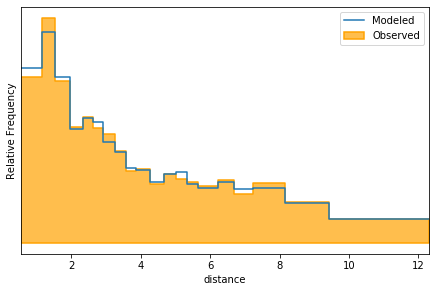

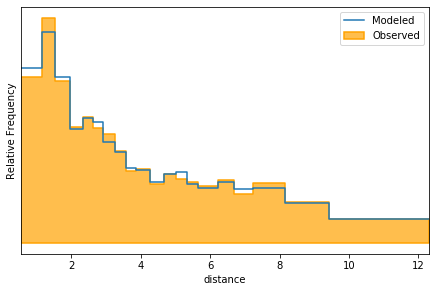

In [26]:
m.distribution_on_idca_variable('distance')

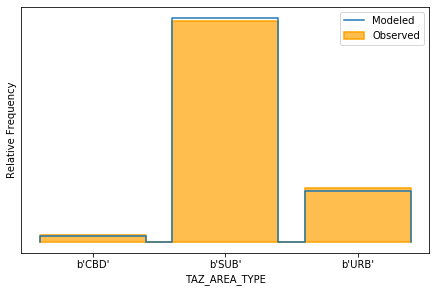

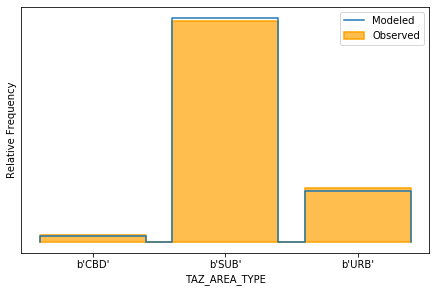

In [27]:
m.distribution_on_idca_variable(
    m.dataservice.data_ca.TAZ_AREA_TYPE
)

The `distribution_on_idca_variable` has a variety of options, 
for example to control the number and range of the histogram bins:

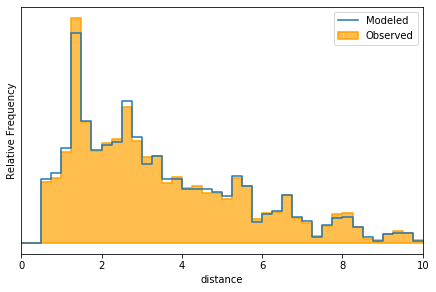

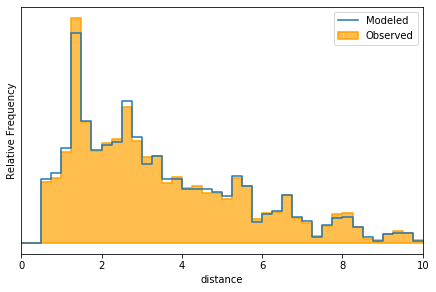

In [28]:
m.distribution_on_idca_variable('distance', bins=40, range=(0,10))

Alternatively, the histogram style can be swapped out for a smoothed 
[kernel density function](https://en.wikipedia.org/wiki/Kernel_density_estimation),
by setting the `style` argument to `'kde'`.

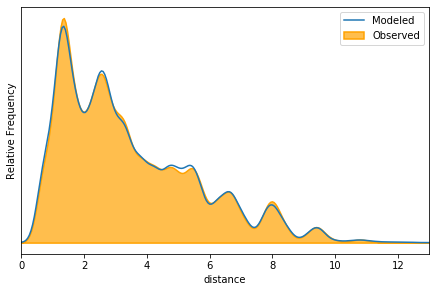

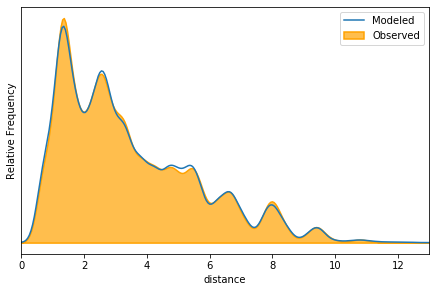

In [29]:
m.distribution_on_idca_variable(
    'distance',
    style='kde',
    range=(0,13),
)

Subsets of the observations can be pulled out, 
to observe the distribution conditional on other 
*idco* factors, like income.

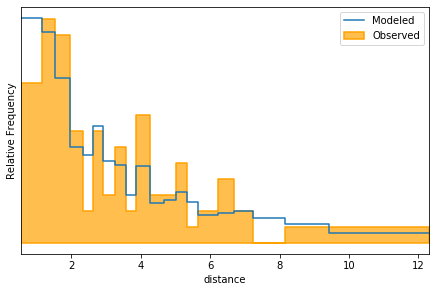

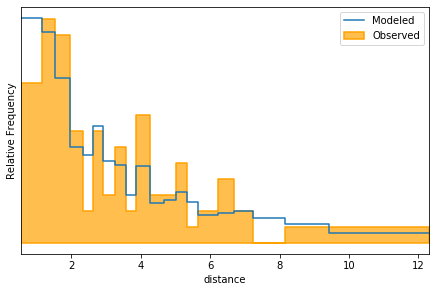

In [30]:
m.distribution_on_idca_variable(
    'distance',
    subselector='INCOME<10000',
)

It is also possible to customize some cosmetic parts of
the generated figure, for example attaching a title or
giving a more detailed and well formatted label for the
x-axis.

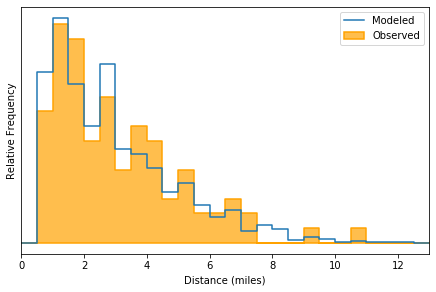

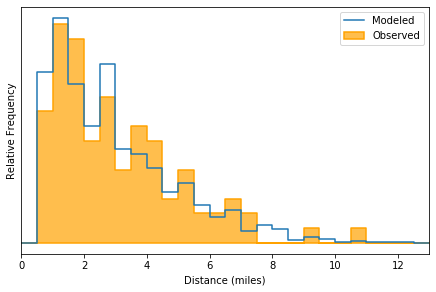

In [31]:
m.distribution_on_idca_variable(
    'distance',
    xlabel="Distance (miles)",
    bins=26,
    subselector='INCOME<10000',
    range=(0,13),
    header='Destination Distance, Very Low Income (<$10k) Households',
)

Alternatively, a `matplotlib.Axes` instance can be passed to the 
`distribution_on_idca_variable` function as the `ax` argument, and
the figure will be drawn there.  This allows full customizability
of the rest of the figure using the usual matplotlib features.

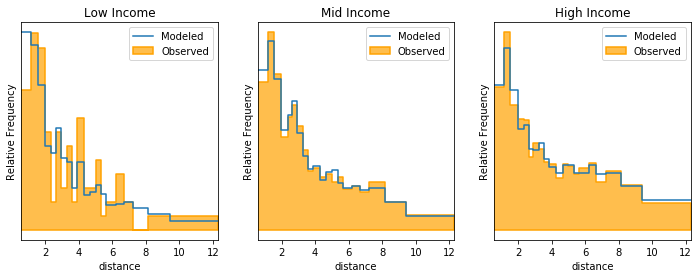

In [32]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1,3, figsize=(12,4))

income_categories = {
    'Low Income': 'INCOME<10000',
    'Mid Income': '(10000<=INCOME) & (INCOME<50000)',
    'High Income': 'INCOME>=50000',
}

for ax, (inc_title, inc) in zip(axes, income_categories.items()):
    m.distribution_on_idca_variable(
        'distance',
        subselector=inc,
        ax=ax,
        range=(0,13),
    )
    ax.set_title(inc_title)

## Save and Report Model

If we are satisified with this model, or if we just want to record 
it as part of our workflow while exploring different model
structures, we can write the model out to a report.  To do so,
we can instantiatie a `larch.Reporter` object.

In [33]:
report = larch.Reporter(title=m.title)

Then, we can push section headings and report pieces into the
report using the "<<" operator.

In [34]:
report << '# Parameter Summary' << m.parameter_summary()

<xmle.Elem 'div' with 3 children>

In [35]:
report << "# Estimation Statistics" << m.estimation_statistics()

<xmle.Elem 'div' with 5 children>

In [36]:
report << "# Utility Functions" << m.utility_functions()

+ P.logsum * X.logsum + P.distance * X.distance + P.Theta * log( + exp(P.EmpRetail_HighInc) * X('RETAIL_EMP * (INCOME>50000)') + exp(P.EmpNonRetail_HighInc) * X('NONRETAIL_EMP*(INCOME>50000)') + exp(P.EmpRetail_LowInc) * X('RETAIL_EMP*(INCOME<=50000)') + exp(P.EmpNonRetail_LowInc) * X('NONRETAIL_EMP*(INCOME<=50000)'))


Once we have assembled the report, we can save the file to 
disk as an HTML report containing the content previously 
assembled. Attaching the model itself to the report as
metadata can be done within the `save` method, which will
allow us to directly reload the same model again later.

In [37]:
report.save(
    '/tmp/exampville_destination_choice.html', 
    overwrite=True, 
    metadata=m,
)

'/tmp/exampville_destination_choice.html'